In [2]:
import os

device = '1,2,3,4,6,7'
device = str(device).strip().lower().replace('cuda:', '').replace('none', '')
os.environ['CUDA_VISIBLE_DEVICES'] = device

import torch

print(torch.cuda.is_available())
print(device)
print(type(device))
print(torch.__version__)  # 检查 PyTorch 版本
print(torch.version.cuda)  # 检查 PyTorch 使用的 CUDA 版本
print(torch.cuda.is_available())  # 检查 CUDA 是否可用
print(torch.cuda.device_count() >= len(device.replace(',', '')))
print(torch.cuda.device_count())
print(torch._C._cuda_getDeviceCount())
print(torch.cuda._nvml_based_avail())

True
1,2,3,4,6,7
<class 'str'>
2.1.2
12.1
True
True
6
6
False


In [ ]:
# coco annotations -> yolo labels
import os
import json
from tqdm import tqdm

def convert_bbox(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = box[0] + box[2] / 2.0
    y = box[1] + box[3] / 2.0
    w = box[2]
    h = box[3]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return (x, y, w, h)

def create_label_file(image_info, annotations, label_dir, category_map):
    image_id = image_info['id']
    image_width = image_info['width']
    image_height = image_info['height']
    image_filename = image_info['file_name']
    label_filename = os.path.splitext(image_filename)[0] + '.txt'
    label_path = os.path.join(label_dir, label_filename)
    
    with open(label_path, 'w') as label_file:
        for ann in annotations:
            if ann['image_id'] == image_id:
                category_id = ann['category_id']
                if category_id in category_map:
                    category_idx = category_map[category_id]
                    bbox = convert_bbox((image_width, image_height), ann['bbox'])
                    label_file.write(f"{category_idx} {' '.join(map(str, bbox))}\n")

def main():
    # 文件路径
    train_json_path = '/home/lisiqi/zhouzhixiang/datasets/annotations/instances_train2017.json'
    val_json_path = '/home/lisiqi/zhouzhixiang/datasets/annotations/instances_val2017.json'
    train_label_dir = '/home/lisiqi/zhouzhixiang/datasets/labels/train2017'
    val_label_dir = '/home/lisiqi/zhouzhixiang/datasets/labels/val2017'
    os.makedirs(train_label_dir, exist_ok=True)
    os.makedirs(val_label_dir, exist_ok=True)
    
    # 加载 COCO 标注文件
    with open(train_json_path, 'r') as f:
        train_data = json.load(f)
    with open(val_json_path, 'r') as f:
        val_data = json.load(f)
    
    # images_subset = val_data['images'][:20]
    # annotations_subset = val_data['annotations'][:20]

    # # 使用 zip 函数将两个列表的元素一一对应
    # for image_info, annotation_info in zip(images_subset, annotations_subset):
    #     print(f"Image Info: {image_info}")
    #     print(f"Annotation Info: {annotation_info}")
    #     print("-" * 50)

    image_annotations_map = {}
    for ann in train_data['annotations']:
        image_id = ann['image_id']
        if image_id not in image_annotations_map:
            image_annotations_map[image_id] = []
        image_annotations_map[image_id].append(ann)

    # 创建类别映射
    category_map = {category['id']: idx for idx, category in enumerate(train_data['categories'])}
    
    # 转换训练集标注
    for image_info in tqdm(train_data['images'], desc='Processing train images'):
        image_id = image_info['id']
        annotations = image_annotations_map.get(image_id, [])
        create_label_file(image_info, annotations, train_label_dir, category_map)
    
    image_annotations_map = {}
    for ann in val_data['annotations']:
        image_id = ann['image_id']
        if image_id not in image_annotations_map:
            image_annotations_map[image_id] = []
        image_annotations_map[image_id].append(ann)

    # 转换验证集标注
    for image_info in tqdm(val_data['images'], desc='Processing val images'):
        image_id = image_info['id']
        annotations = image_annotations_map.get(image_id, [])
        create_label_file(image_info, annotations, val_label_dir, category_map)

main()


In [2]:
import random
import os
import json
import cv2
import matplotlib.pyplot as plt

# 设置路径
train_image_dir = '/home/lisiqi/zhouzhixiang/datasets/images/train2017'
val_image_dir = '/home/lisiqi/zhouzhixiang/datasets/images/val2017'
train_label_dir = '/home/lisiqi/zhouzhixiang/datasets/labels/train2017'
val_label_dir = '/home/lisiqi/zhouzhixiang/datasets/labels/val2017'


# 获取图片文件列表
def get_image_files(image_dir):
    return [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]

# 解析YOLO格式标签
def parse_yolo_label(label_path, image_width, image_height):
    boxes = []
    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])
            
            # 将归一化坐标转换为像素坐标
            x_min = (x_center - width / 2) * image_width
            y_min = (y_center - height / 2) * image_height
            x_max = (x_center + width / 2) * image_width
            y_max = (y_center + height / 2) * image_height
            
            boxes.append((class_id, x_min, y_min, x_max, y_max))
    return boxes

# 随机选取并可视化图片及标签
def visualize_random_images(image_dir, label_dir, category_map, num_images=10):
    image_files = get_image_files(image_dir)
    
    # 随机选择图片
    selected_images = random.sample(image_files, num_images)
    
    # 为每个类别分配不同的颜色
    colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255), (255, 0, 255), (128, 128, 0), (0, 128, 128)]
    
    for image_file in selected_images:
        # 读取图片
        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        image_height, image_width, _ = image.shape
        
        # 读取对应的标签文件
        label_file = os.path.splitext(image_file)[0] + '.txt'
        label_path = os.path.join(label_dir, label_file)
        boxes = parse_yolo_label(label_path, image_width, image_height)
        
        # 绘制边界框
        for box in boxes:
            class_id, x_min, y_min, x_max, y_max = box
            color = colors[class_id % len(colors)]  # 使用类别ID来分配颜色
            cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), color, 2)
            
            # 在右上角显示类别名称
            label_name = category_map.get(class_id)
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(image, label_name, (int(x_min), int(y_min) - 10), font, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
        
        # 在左上角显示图片名称
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image, image_file, (10, 30), font, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # 使用matplotlib展示图片
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')  # 不显示坐标轴
        plt.show()


val_json_path = '/home/lisiqi/zhouzhixiang/datasets/annotations/instances_val2017.json'
with open(val_json_path, 'r') as f:
    val_data = json.load(f)
# 从训练数据中获取类别映射
category_map = {idx: category['name'] for idx, category in enumerate(val_data['categories'])}

# 可视化训练集和验证集的随机图片
visualize_random_images(train_image_dir, train_label_dir, category_map)
visualize_random_images(val_image_dir, val_label_dir, category_map)

In [2]:
check_dirs = ['/home/lisiqi/zhouzhixiang/datasets/images/train2017', '/home/lisiqi/zhouzhixiang/datasets/images/val2017',
              '/home/lisiqi/zhouzhixiang/datasets/labels/train2017', '/home/lisiqi/zhouzhixiang/datasets/labels/val2017']
import os
for dir in check_dirs:
    print(len(os.listdir(dir)))

118287
5000
118287
5000


In [13]:
import os
import random
import shutil

# 设置源数据集和目标数据集路径
SOURCE_ROOT = '/home2/zhouzhixiang/datasets/coco'
NEW_ROOT = '/home2/zhouzhixiang/datasets/subCoco'

# 设置目录路径
train_image_dir = os.path.join(SOURCE_ROOT, 'images', 'train2017')
val_image_dir = os.path.join(SOURCE_ROOT, 'images', 'val2017')
train_label_dir = os.path.join(SOURCE_ROOT, 'labels', 'train2017')
val_label_dir = os.path.join(SOURCE_ROOT, 'labels', 'val2017')

new_train_image_dir = os.path.join(NEW_ROOT, 'images', 'train2017')
new_val_image_dir = os.path.join(NEW_ROOT, 'images', 'val2017')
new_train_label_dir = os.path.join(NEW_ROOT, 'labels', 'train2017')
new_val_label_dir = os.path.join(NEW_ROOT, 'labels', 'val2017')

# 创建新目录结构
os.makedirs(new_train_image_dir, exist_ok=True)
os.makedirs(new_val_image_dir, exist_ok=True)
os.makedirs(new_train_label_dir, exist_ok=True)
os.makedirs(new_val_label_dir, exist_ok=True)

# 获取文件列表
def get_image_files(image_dir):
    return [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]

def get_label_files(label_dir):
    return [f for f in os.listdir(label_dir) if f.endswith('.txt')]

# 随机选择子集
def select_subset(image_files, label_files, ratio):
    num_images = len(image_files)
    num_selected = int(num_images * ratio)
    selected_images = random.sample(image_files, num_selected)
    selected_labels = [f.replace('.jpg', '.txt').replace('.png', '.txt') for f in selected_images]
    return selected_images, selected_labels

# 复制文件到新目录
def copy_files(selected_images, selected_labels, source_image_dir, source_label_dir, new_image_dir, new_label_dir):
    for image_file, label_file in zip(selected_images, selected_labels):
        # 复制图片
        src_image_path = os.path.join(source_image_dir, image_file)
        dst_image_path = os.path.join(new_image_dir, image_file)
        shutil.copy(src_image_path, dst_image_path)

        # 复制标签文件
        src_label_path = os.path.join(source_label_dir, label_file)
        dst_label_path = os.path.join(new_label_dir, label_file)
        shutil.copy(src_label_path, dst_label_path)

# 获取训练集和验证集的图片和标签文件
train_image_files = get_image_files(train_image_dir)
train_label_files = get_label_files(train_label_dir)

val_image_files = get_image_files(val_image_dir)
val_label_files = get_label_files(val_label_dir)

# 随机选择训练集和验证集子集
selected_train_images, selected_train_labels = select_subset(train_image_files, train_label_files, ratio=1/10)
selected_val_images, selected_val_labels = select_subset(val_image_files, val_label_files, ratio=1/5)

# 复制选中的文件到新目录
copy_files(selected_train_images, selected_train_labels, train_image_dir, train_label_dir, new_train_image_dir, new_train_label_dir)
copy_files(selected_val_images, selected_val_labels, val_image_dir, val_label_dir, new_val_image_dir, new_val_label_dir)

print(f"Successfully created subset in {NEW_ROOT}")

for dir in [new_train_image_dir, new_val_image_dir, new_train_label_dir, new_val_label_dir]:
    print(len(os.listdir(dir)))


Successfully created subset in /home2/zhouzhixiang/datasets/subCoco
11828
1000
11828
1000


In [4]:
import torch
import torch.nn.functional as F

# 创建一个带梯度的张量
x = torch.randn(1, 4, 2, 2, requires_grad=True)

# 使用 Pixel Shuffle（上采样）
# y = F.pixel_shuffle(x, upscale_factor=2)
fuc = torch.nn.PixelShuffle(upscale_factor=2)
y = fuc(x)

# 计算损失并进行反向传播
loss = y.sum()  # 简单的求和损失
loss.backward()

# 查看梯度是否存在
print(x.grad)  # 输出梯度，不为 None，说明梯度传播成功


tensor([[[[1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.]]]])


In [1]:
import torch

a = torch.tensor([[1, 2], [3, 4]])  # 2x2
b = torch.tensor([[5, 6], [7, 8]])  # 2x2

c = torch.cat((a, b), dim=0)  # 在行（dim=0）方向拼接
print(c)


tensor([[1, 2],
        [3, 4],
        [5, 6],
        [7, 8]])


In [7]:
import torch

torch.set_printoptions(threshold=5000, linewidth=500)

def build_graph_adj(features, k):
    """
    构造图的邻接矩阵。
    
    参数:
      features: tensor，形状为 (B, 5*x, d)
      k: 每列选择最小距离的 k 个点
      
    返回:
      adj: 布尔类型 tensor，形状为 (B, x, x)
           True 表示在图中对应的两个节点之间有边连接
    """
    B, N, d = features.shape
    assert N % 5 == 0, "总特征数必须为5的倍数"
    x = N // 5  # 每组特征数

    # 1. 计算两两之间的距离矩阵，形状 (B, N, N)
    #    使用默认的欧氏距离 p=2
    D = torch.cdist(features, features, p=2)  # (B, 5x, 5x)

    # 2. 对于每列选取最小的 k 个距离（注意这里 dim=1 表示沿着“行”搜索，即每列）
    #    topk 返回的 indices 形状为 (B, k, N)
    #    因为对于每个 batch 中的每一列（第2个维度），都找 k 个“行索引”
    print(D)
    topk_vals, topk_indices = torch.topk(D, k=k, dim=1, largest=False)

    print(topk_indices)

    # 3. 构造布尔 mask，大小为 (B, N, N)，每列中 k 个位置为 True
    mask = torch.zeros_like(D, dtype=torch.bool)
    # 构造 batch 和列的索引
    batch_idx = torch.arange(B, device=features.device).view(B, 1, 1).expand(B, k, N)
    col_idx = torch.arange(N, device=features.device).view(1, 1, N).expand(B, k, N)
    mask[batch_idx, topk_indices, col_idx] = True

    print (mask)

    # 4. 将行进行归并：按照行索引 mod x 来分成 x 组，每组包含 5 行（因为总行数为 5*x）
    #    先将 mask 的第一维（行）reshape为 (B, 5, x, N)
    mask_rows = mask.view(B, 5, x, N)  # (B, 5, x, 5*x)
    # 对于每个组，逻辑或（any）操作，沿第2维（5个组内的行）做合并，得到 (B, x, N)
    mask_rows = mask_rows.any(dim=1)  # (B, x, 5*x)

    print(mask_rows)

    # 5. 将列也按相同规则归并：先将列 reshape 为 (B, x, 5, x)
    mask_final = mask_rows.view(B, x, 5, x).any(dim=2)  # (B, x, x)
    
    return mask_final

# ------------------------
# 示例：
B = 1
x_num = 4  # 每组有 10 个特征
d = 5      # 特征维度
# 总特征数为 5*x_num
features = torch.randn(B, 5 * x_num, d, device='cuda')  # 假设在 GPU 上

k = 2  # 每列选择最小距离的 3 个
adj = build_graph_adj(features, k)  # 得到 (B, x, x) 的邻接矩阵
print(adj.shape)  # 应输出: torch.Size([2, 10, 10])
print(adj)


tensor([[[0.0000, 3.8022, 3.6002, 4.1752, 3.5720, 4.2190, 3.2906, 3.2917, 3.9849, 3.2320, 3.8853, 3.9491, 2.2561, 3.8040, 3.9201, 4.4705, 3.4468, 2.9607, 4.5408, 2.4269],
         [3.8022, 0.0000, 1.6926, 2.1360, 3.5634, 4.4798, 3.7722, 2.5306, 2.7258, 2.5299, 1.7891, 2.0779, 1.9096, 2.1264, 3.4497, 2.5987, 4.5306, 2.9936, 2.8719, 3.3840],
         [3.6002, 1.6926, 0.0000, 2.6878, 3.2307, 3.0466, 2.6879, 1.5502, 2.0167, 1.7281, 1.0512, 3.0730, 2.3083, 1.9661, 3.0730, 2.8158, 3.2141, 2.3215, 2.4014, 2.7131],
         [4.1752, 2.1360, 2.6878, 0.0000, 2.8385, 4.0843, 3.8869, 2.9449, 2.1491, 2.7911, 2.3213, 2.0497, 2.3199, 1.4107, 3.3010, 4.1756, 4.7120, 3.1265, 1.8213, 3.7656],
         [3.5720, 3.5634, 3.2307, 2.8385, 0.0000, 3.0976, 2.0994, 2.0182, 1.8890, 1.7223, 3.6601, 3.2743, 2.4369, 2.0041, 4.0321, 3.9393, 3.5443, 1.5007, 2.2565, 2.0951],
         [4.2190, 4.4798, 3.0466, 4.0843, 3.0976, 0.0000, 2.2354, 2.5673, 2.5069, 2.6436, 3.2744, 4.8944, 3.9852, 3.0864, 3.6453, 5.0704, 2.2620,

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

def load_csv(file_path):
    # 读取 CSV 文件，处理列名中的空格
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()  # 去掉列名中的空格
    return df

file_path = '/home2/zhouzhixiang/Hyper-YOLOv1.1/runs/train/shuffleAndSplityolov9-s40x40-k30/results.csv'
df = load_csv(file_path)

max_value = df['metrics/mAP_0.5'].max()
max_row = df[df['metrics/mAP_0.5'] == max_value]
print(f'mAP50: {max_value}')
print(f'mAP50:95: {max_row["metrics/mAP_0.5:0.95"].values[0]}')


mAP50: 0.47778
mAP50:95: 0.33118


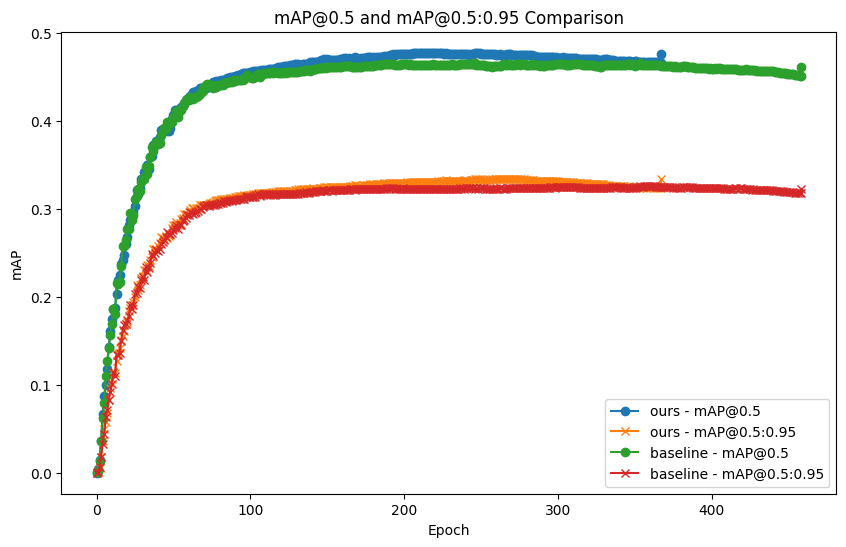

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取 CSV 文件并去掉列名中的空格
def load_csv(file_path):
    # 读取 CSV 文件，处理列名中的空格
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()  # 去掉列名中的空格
    return df

# 加载两个 CSV 文件
file_path_1 = '/home2/zhouzhixiang/Hyper-YOLOv1.1/runs/train/shuffleAndSplityolov9-s40x40-k30/results.csv'  # 假设文件1的路径
file_path_2 = '/home2/zhouzhixiang/Hyper-YOLOv1.1/runs/train/yolov9-s-hyper-baseline/results.csv'  # 假设文件2的路径

df1 = load_csv(file_path_1)
df2 = load_csv(file_path_2)

# 创建图形
plt.figure(figsize=(10, 6))

# 绘制第一个文件的 mAP 指标
plt.plot(df1['epoch'], df1['metrics/mAP_0.5'], label='ours - mAP@0.5', marker='o')
plt.plot(df1['epoch'], df1['metrics/mAP_0.5:0.95'], label='ours - mAP@0.5:0.95', marker='x')

# 绘制第二个文件的 mAP 指标
plt.plot(df2['epoch'], df2['metrics/mAP_0.5'], label='baseline - mAP@0.5', marker='o')
plt.plot(df2['epoch'], df2['metrics/mAP_0.5:0.95'], label='baseline - mAP@0.5:0.95', marker='x')

# 添加标签和标题
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('mAP@0.5 and mAP@0.5:0.95 Comparison')

# 显示图例
plt.legend()

# 显示图形
plt.show()


In [ ]:
# 测试 SplitHyperComputeModule 运行时间
from models.common import *
import torch
import time

c1 = 1280
c2 = 256
B = 2  # batch size
H, W = 20, 20  # height and width of the input feature map

# 假设我们有一个输入，5个相同形状的Tensor，形状为 (B, C, H, W)
x = [torch.randn(B, c2, H, W, device=torch.device('cuda:0')) for _ in range(5)]  # 5个相同形状的张量列表，每个形状为 (B, C, H, W)
# x = torch.randn(B, c2, H, W, device=torch.device('cuda:0'))

# 创建模型
model = SplitHyperComputeModule(c1, c2).to(torch.device('cuda:0'))
# output, _, _ = model(x)
# s1, s2 = 0.0, 0.0

# for _ in range(50):
#     _, t1, t2 = model(x)
#     s1 = s1+t1
#     s2 = s2+t2
# print(f"SplitHyper: s1={s1/50.0}, s2={s2/50.0}")


# x = torch.randn(B, 256, 40, 40, device=torch.device('cuda:0'))
# model = HyperComputeModule(256, 256).to(torch.device('cuda:0'))
output, _, _, _, _, _ = model(x)
s1, s2, s3, s4, s5 = 0.0, 0.0, 0.0, 0.0, 0.0

for _ in range(50):
    _, t1, t2, t3, t4, t5 = model(x)
    s1 = s1+t1
    s2 = s2+t2
    s3 = s3+t3
    s4 = s4+t4
    s5 = s5+t5
s1 = s1/50.0
s2 = s2/50.0
s3 = s3/50.0
s4 = s4/50.0
s5 = s5/50.0
to = s1 + s2 + s3 + s4 + s5

print(f"SplitHyper: cdist={s1:.5f}, topk={s2:.5f}, mask={s3:.5f}, mask_rows={s4:.5f}, mask_final={s5:.5f}")
print(f"{s1/to:.5f} {s2/to:.5f} {s3/to:.5f} {s4/to:.5f} {s5/to:.5f}")


# 20x20
# SplitHyper: cdist=0.00141, topk=0.00171, mask=0.00128, mask_rows=0.00049, mask_final=0.00038
# 0.26709 0.32451 0.24323 0.09218 0.07299

# 40x40
# SplitHyper: cdist=0.01590, topk=0.02635, mask=0.00296, mask_rows=0.00117, mask_final=0.00069
# 0.33774 0.55993 0.06286 0.02479 0.01467

SplitHyper: cdist=0.00141, topk=0.00171, mask=0.00128, mask_rows=0.00049, mask_final=0.00038
0.26709 0.32451 0.24323 0.09218 0.07299


In [5]:
import torch
import torch.nn.functional as F

# 创建一个随机的 (1, 4, 4, 4) 张量
x = torch.randn(16, 32, 320, 320, device=torch.device('cuda:0'))

# 进行 pixel_unshuffle，块大小为 2
y = F.pixel_unshuffle(x, downscale_factor=4)

# 检查是否是连续的
print(y.is_contiguous())  # 输出: False（通常情况下）


True
